# Heatmaps creator
Save in .pkl format
draw_heatmaps: Using cv2 weighted overlay

In [14]:
import os
import sys

base_dir = ".."
if not base_dir in sys.path:
    sys.path.append(base_dir)

%load_ext autoreload
%autoreload 2

print(sys.path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['/home/keerthanaprasad/RajithaKV/ROI_Detection/CLAM_model/CLAM_1/notebooks', '/home/keerthanaprasad/anaconda3/envs/clam/lib/python37.zip', '/home/keerthanaprasad/anaconda3/envs/clam/lib/python3.7', '/home/keerthanaprasad/anaconda3/envs/clam/lib/python3.7/lib-dynload', '', '/home/keerthanaprasad/anaconda3/envs/clam/lib/python3.7/site-packages', '/home/keerthanaprasad/anaconda3/envs/clam/lib/python3.7/site-packages/topk-1.0-py3.7.egg', '/home/keerthanaprasad/anaconda3/envs/clam/lib/python3.7/site-packages/IPython/extensions', '/home/keerthanaprasad/.ipython', '/home/keerthanaprasad/RajithaKV/ROI_Detection/CLAM_model/CLAM_1/notebooks', '/home/keerthanaprasad/RajithaKV/ROI_Detection/CLAM_model/CLAM_1/notebooks', '..']


In [15]:
from PIL import Image
import torch
import os
import shutil
import yaml
import argparse
import numpy as np
import pickle
from itertools import product
from modules.utils import *
from modules.file_utils import save_pkl, load_pkl
from modules.resnet_custom import resnet50_baseline
from modules.model_clam import CLAM_MB, CLAM_SB
from torch.utils.data import DataLoader
from scipy.stats import percentileofscore
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import cv2 as cv
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

## Config

In [31]:
drop_out = False
n_classes = 2
splits = [0, 1, 2, 3, 4]
model_type = "clam_sb" 
model_size = "small"
exp_codes = [
    "exp_131_s1"
]
results_dir = "../experiments/results/" #_saved/results_8/

data_dir = "../experiments/annotations/original/"
image_ext = ".tif"
patch_dir = '../experiments/patches/'
feat_dir = "../experiments/features/"
split_dir = "../experiments/splits/fungal_vs_nonfungal_100_af_98"
annot_dir = "../experiments/annotations/patches/tile_annotations_overlap/"

select_image = [
    "F006a02",
    "F007a02",
]
run_heatmap_dict = False
run_draw_heatmaps = True
delete_previous = False
only_test_split = True
use_overlap = True
overlap = 0.5
show_labels = False
get_patch_acc = True

### Draw heatmaps config
patch_size = (256, 256)
blur = (128, 128)
alpha = 1
beta = 0.0
gamma = 0.0
cmap = 'coolwarm'
threshold = 0.5

## Heatmaps

In [32]:
def score2percentile(score, ref):
    percentile = percentileofscore(ref, score)
    return percentile

In [33]:
def compute_from_patches(clam_pred=None, model=None, feature_extractor=None, batch_size=512,
    attn_save_path=None, ref_scores=None, feat_save_path=None):

    heatmap_dict = []

    # Load the dataset
    # Create dataset from the image patches
    for index, folder in enumerate(sorted(os.listdir(patch_dir))):
        # if index not in select_image:
        #     continue

        filename = str(folder).split("/")[-1]
        if filename == "fungal_vs_nonfungal_resnet_features":
            continue

        if filename not in select_image:
            continue

        patch_folder = os.path.join(patch_dir, folder)
        dataset = []
        for patch_file in sorted(os.listdir(patch_folder)):
            if patch_file == "pt_files":
                continue

            img_path = os.path.join(patch_folder, patch_file)

            img = Image.open(img_path)

            img_arr = np.asarray(img)
            # img_arr = np.expand_dims(img_arr, 0)
            # img_PIL = Image.fromarray(img_arr)

            # Create the dataset loader
            imgs = torch.tensor(img_arr)

            # Get coord in [x, y] format
            coord = img_path.split("/")
            coord = coord[-1]
            coord = coord.split(".")[-2]
            coord = coord.split("_")
            coord = [int(coord[-2]), int(coord[-1])]

            dataset.append([imgs, coord])

        roi_loader = DataLoader(dataset=dataset, batch_size=24)
        print("File:", filename)

        num_batches = len(roi_loader)
        print('number of batches: ', len(roi_loader)) # len(roi_loader) = 24 / (batch_size)
        mode = "w"

        attention_scores = []
        coords_list = []

        for idx, (roi, coords) in enumerate(roi_loader):
            roi = roi.to(device)

            with torch.no_grad():
                roi = roi.reshape([24, 3, 256, 256])
                roi = roi.float()
                features = feature_extractor(roi)

                if attn_save_path is not None:
                    A = model(features, attention_only=True)
                    A = F.softmax(A, dim=1)  # softmax over N

                    if A.size(0) > 1: #CLAM multi-branch attention
                        if clam_pred:
                            A = A[clam_pred]

                    A = A.view(-1, 1).cpu().numpy()

                    if ref_scores is not None:
                        for score_idx in range(len(A)):
                            A[score_idx] = score2percentile(A[score_idx], ref_scores)

                    # Save
                    attention_scores.append(A)
                    coords_list.append(coords)

    #             if idx % math.ceil(num_batches * 0.05) == 0:
    #                 print('procssed {} / {}'.format(idx, num_batches))

            if feat_save_path is not None:
                asset_dict = {'features': features.cpu().numpy(), 'coords': coords}
                # Save # TBD. Not required

            heatmap_dict.append({"filename": filename, "attention_scores": attention_scores, "coords_list": coords_list})

            mode = "a"
    return heatmap_dict


def compute_from_patches_overlap(clam_pred=None, model=None, feature_extractor=None, batch_size=512,
    attn_save_path=None, ref_scores=None, feat_save_path=None, test_split=None):

    heatmap_dict = []

    if only_test_split:
        select_image = test_split

    # Load the dataset
    # Create dataset from the image patches
    for index, image_file in enumerate(sorted(os.listdir(data_dir))):
        # if index not in select_image:
        #     continue
        filename, ext = os.path.splitext(image_file)
        if filename not in select_image:
            continue
        img = Image.open(os.path.join(data_dir, image_file))
        w, h = img.size
        d = patch_size[0]

        dataset = []
        count = 0
        step = int(d*(1-overlap))
        grid = product(range(0, h-h%d-d+1, step), range(0, w-w%d-d+1, step))
        for i, j in grid:
            box = (j, i, j+d, i+d)
            count += 1
            patch = img.crop(box)
            patch_arr = np.asarray(patch)
            # img_arr = np.expand_dims(img_arr, 0)
            # img_PIL = Image.fromarray(img_arr)

            # Create the dataset loader
            patch_tensor = torch.tensor(patch_arr)

            # Get coord in [x, y] format
            coord = [int(i), int(j)]

            dataset.append([patch_tensor, coord])

        roi_loader = DataLoader(dataset=dataset, batch_size=count)
        print("File:", filename)

        num_batches = len(roi_loader)
        print('number of batches: ', len(roi_loader)) # len(roi_loader) = count / (batch_size)
        mode = "w"

        attention_scores = []
        coords_list = []

        for idx, (roi, coords) in enumerate(roi_loader):
            roi = roi.to(device)

            with torch.no_grad():
                roi = roi.reshape([count, 3, patch_size[0], patch_size[1]])
                roi = roi.float()
                features = feature_extractor(roi)

                if attn_save_path is not None:
                    A = model(features, attention_only=True)
                    # A = F.softmax(A, dim=1)  # softmax over N

                    if A.size(0) > 1: #CLAM multi-branch attention
                        if clam_pred:
                            A = A[clam_pred]

                    A = A.view(-1, 1).cpu().numpy()

                    if ref_scores is not None:
                        for score_idx in range(len(A)):
                            A[score_idx] = score2percentile(A[score_idx], ref_scores)

                    # Save
                    attention_scores.append(A)
                    coords_list.append(coords)

            # if idx % math.ceil(num_batches * 0.05) == 0:
            #     print('procssed {} / {}'.format(idx, num_batches))

            if feat_save_path is not None:
                asset_dict = {'features': features.cpu().numpy(), 'coords': coords}
                # Save # TBD. Not required

            heatmap_dict.append({"filename": filename, "attention_scores": attention_scores, "coords_list": coords_list})

            mode = "a"
    return heatmap_dict


def generate_heatmap_dict(exp_code, use_overlap=True):
    """
    Run saved model on select images for generating heatmap info.
    """
    feature_extractor = resnet50_baseline(pretrained=True)
    feature_extractor.eval()
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if torch.cuda.device_count() > 1:
        device_ids = list(range(torch.cuda.device_count()))
        feature_extractor = nn.DataParallel(feature_extractor, device_ids=device_ids).to('cuda:0')
    else:
        feature_extractor = feature_extractor.to(device)
    feature_extractor.eval()

    # Load model
    model_dict = {"dropout": drop_out, 'n_classes': n_classes}

    if model_size is not None and model_type in ['clam_sb', 'clam_mb']:
        model_dict.update({"size_arg": model_size})

    if model_type =='clam_sb':
        model = CLAM_SB(**model_dict)
    elif model_type =='clam_mb':
        model = CLAM_MB(**model_dict)
    else: # model_type == 'mil'
        if n_classes > 2:
            model = MIL_fc_mc(**model_dict)
        else:
            model = MIL_fc(**model_dict)

    print_network(model)

    for split in splits:
        print("Evaluating attentions scores for split_{}".format(split))

        save_path = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmaps")
        if not os.path.isdir(save_path):
            os.mkdir(save_path)
        ref_scores = None
        Y_hats = None
        ckpt_path = "s_"+str(split)+"_checkpoint.pt"
        ckpt_path = os.path.join(results_dir, exp_code, "splits_"+str(split), ckpt_path)

        ckpt = torch.load(ckpt_path)
        ckpt_clean = {}
        for key in ckpt.keys():
            if 'instance_loss_fn' in key:
                continue
            ckpt_clean.update({key.replace('.module', ''):ckpt[key]})

        # Replace 3 with 2.
        ckpt_clean_2 = {}
        for key, value in ckpt_clean.items():
            new_key = key.replace("3", "2") if "3" in key else key
            ckpt_clean_2[new_key] = value
        model.load_state_dict(ckpt_clean_2, strict=True)

        model.relocate()
        model.eval()

        if only_test_split:
            csv_path = '{}/splits_{}.csv'.format(split_dir, split)
            df = pd.read_csv(csv_path)
            test_split = df[df['test'].notnull()]['test']
            test_split = list(test_split)
        else:
            test_split = None

        if use_overlap:
            heatmap_dict = compute_from_patches_overlap(model=model, feature_extractor=feature_extractor, batch_size=512, attn_save_path=save_path, ref_scores=ref_scores, test_split=test_split)
        else:
            heatmap_dict = compute_from_patches(model=model, feature_extractor=feature_extractor, batch_size=512, attn_save_path=save_path,  ref_scores=ref_scores)

        heatmap_dict_save = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl")
        save_pkl(heatmap_dict_save, heatmap_dict)
        print()

    print("Done!")


def draw_heatmaps(exp_code, cmap='coolwarm'):
    """
    Plot and save the heatmaps.
    """
    for split in splits:
        ckpt_path = "s_"+str(split)+"_checkpoint.pt"
        save_path = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmaps")
        if delete_previous:
            os.remove(save_path)
        if not os.path.isdir(save_path):
            os.mkdir(save_path)

        heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl"))

        for image_file in heatmap_dict:
            image_name = image_file['filename']
            attention_scores = image_file['attention_scores']
            coords_list = image_file['coords_list']

            plt.clf()
            if isinstance(cmap, str):
                cmap = plt.get_cmap(cmap)

            img_path = os.path.join(data_dir, image_name+image_ext)
            # orig_img = np.array(Image.open(img_path))
            # orig_img = orig_img[0:1024, 0:1536] # No left-overs

            orig_img = cv.imread(img_path)
            orig_img = orig_img[0:1024, 0:1536] # No left-overs


            scores = attention_scores[0].copy()
            scores = [float(x) for x in scores]
            percentiles = []
            for score in scores:
                percentile = percentileofscore(scores, score)
                percentiles.append(percentile/100)
            # print(scores)
            # print()
            # print(percentiles)

            heatmap_mask = np.zeros([1024, 1536, 3])

            for index, block_score in enumerate(percentiles):
                x = 256 * coords_list[0][0][index].item() # Top left corner
                y = 256 * coords_list[0][1][index].item() # Top left corner
                # print("Score, x, y:", score, x, y)
                # print(x, y, x+patch_size[0], y+patch_size[1])

                raw_block = np.ones([256, 256])
                color_block = cmap(raw_block*block_score)[:,:,:3]
                heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], :] = color_block.copy()

                if index % 4 == 0:
                    plt.text(y+0.5*patch_size[1], x+0.5*patch_size[0], str(round(percentiles[index], 4))+"\n"+str(round(scores[index], 4)), fontsize='x-small')

            heatmap_mask = cv.blur(heatmap_mask, tuple(blur))

            img_heatmap_filename = os.path.join(save_path, image_name+"_heatmap"+".png")

            orig_img = orig_img.astype(np.float32)
            orig_img /= 255.0

            alpha = 0.75
            beta = 0.25
            gamma = 0.0
            eps = 1e-8

            img_heatmap = cv.addWeighted(orig_img, alpha, heatmap_mask, beta, gamma, dtype=cv.CV_64F)
            # img_heatmap = orig_img.copy()

            # Normalise
            numer = img_heatmap - np.min(img_heatmap)
            denom = (img_heatmap.max() - img_heatmap.min()) + eps
            img_heatmap = numer / denom

            plt.imshow(img_heatmap)
            plt.savefig(img_heatmap_filename)
            print("Saved", img_heatmap_filename)
        print()


def draw_heatmaps_overlap(exp_code, cmap='coolwarm'):
    """
    Plot and save the heatmaps. Overlap method.
    """
    for split in splits:
        ckpt_path = "s_"+str(split)+"_checkpoint.pt"
        save_path = os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmaps")
        if delete_previous:
            shutil.rmtree(save_path)
        if not os.path.isdir(save_path):
            os.mkdir(save_path)

        if get_patch_acc:
            patch_accuracies = []
            avg_positive_acc_sc = 0
            avg_positive_f1_sc = 0
            avg_positive_sc_counter = 0
        heatmap_dict = load_pkl(os.path.join(results_dir, exp_code, "splits_"+str(split), "heatmap_dict.pkl"))

        for image_file in heatmap_dict:
            image_name = image_file['filename']
            attention_scores = image_file['attention_scores']
            coords_list = image_file['coords_list']
            # print(coords_list)

            plt.clf()
            if isinstance(cmap, str):
                cmap = plt.get_cmap(cmap)

            img_path = os.path.join(data_dir, image_name+image_ext)
            # orig_img = np.array(Image.open(img_path))
            # orig_img = orig_img[0:1024, 0:1536] # No left-overs

            orig_img = cv.imread(img_path)
            orig_img = orig_img[0:1024, 0:1536] # No left-overs

            scores = attention_scores[0].copy()
            scores = [float(x) for x in scores]
            percentiles = []
            for score in scores:
                percentile = percentileofscore(scores, score)
                percentiles.append(percentile/100)
            # print(scores)
            # print()
            # print(percentiles)

            if get_patch_acc:
                patch_annot_path = os.path.join(annot_dir, image_name, image_name+'.pkl')
                if "F" in image_name:
                    patch_annot = load_pkl(patch_annot_path)
                    patch_annot = patch_annot['bin_scores']
                elif "N" in image_name:
                    patch_annot = [1]*len(scores)

                preds = [1 if x >= 0.5 else 0 for x in percentiles]
                acc_sc = accuracy_score(patch_annot, preds)
                f1_sc = f1_score(patch_annot, preds, average='macro')
                patch_accuracies.append({
                    'filename': image_name,
                    'accuracy_score': acc_sc,
                    'f1_score': f1_sc})

                if "F" in image_name:
                    avg_positive_acc_sc += acc_sc
                    avg_positive_f1_sc += f1_sc
                    avg_positive_sc_counter += 1

            heatmap_mask = np.zeros([1024, 1536, 3])
            counter = np.zeros([1024, 1536, 3])

            for index, block_score in enumerate(percentiles):
                x = coords_list[0][0][index].item() # Top left corner
                y = coords_list[0][1][index].item() # Top left corner
                # print("Score, x, y:", block_score, x, y)
                # print(x, y, x+patch_size[0], y+patch_size[1])

                raw_block = np.ones([patch_size[0], patch_size[1]])
                color_block = cmap(raw_block*block_score)[:,:,:3]
                heatmap_mask[x:x+patch_size[0], y:y+patch_size[1], :] += color_block.copy()
                counter[x:x+patch_size[0], y:y+patch_size[1], :] += 1

                if show_labels:
                    plt.text(y+0.5*patch_size[1], x+0.5*patch_size[0], str(math.floor(percentiles[index] * 100))+"\n"+str(math.floor(scores[index] * 1e4)), fontsize='x-small')
            # print(heatmap_mask.shape)

            # Average
            zero_mask = counter == 0
    #             heatmap_mask[~zero_mask] = heatmap_mask[~zero_mask] / counter[~zero_mask]
            del counter

            # Normalise
            # eps = 1e-8
            # numer = heatmap_mask - np.min(heatmap_mask)
            # denom = (heatmap_mask.max() - heatmap_mask.min()) + eps
            # heatmap_mask = numer / denom
            # heatmap_mask = cv.blur(heatmap_mask, tuple(blur))

            img_heatmap_filename = os.path.join(save_path, image_name+"_heatmap"+".png")

            orig_img = orig_img.astype(np.float32)
            orig_img /= 255.0

            alpha = 0.75
            beta = 0.25
            gamma = 0.0
            eps = 1e-8

            blank = np.ones([1024, 1536, 3])
            # img_heatmap = cv.addWeighted(blank, alpha, heatmap_mask, beta, gamma, dtype=cv.CV_64F)
            img_heatmap = heatmap_mask.copy()
            # img_heatmap = orig_img.copy()

            # Normalise
    #             numer = img_heatmap - np.min(img_heatmap)
    #             denom = (img_heatmap.max() - img_heatmap.min()) + eps
    #             img_heatmap = numer / denom

            plt.imshow(img_heatmap)
            plt.savefig(img_heatmap_filename)
            print("Saved", img_heatmap_filename)
        print()

        if get_patch_acc:
            avg_positive_acc_sc /= avg_positive_sc_counter
            avg_positive_f1_sc /= avg_positive_sc_counter
            patch_accuracies.append({
                'avg_positive_acc_sc': avg_positive_acc_sc,
                'avg_positive_f1_sc': avg_positive_f1_sc
                })

            acc_dict_save = os.path.join(results_dir, exp_code, "splits_"+str(split), "acc_dict.pkl")
            save_pkl(acc_dict_save, patch_accuracies)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_0/heatmaps/F005a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_0/heatmaps/F006a01_heatmap.png



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F006a08_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F007a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F007a13_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F007a21_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F010a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F012a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F013a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F013a12_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F017a08_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F018a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F021a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F030a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F030a13_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F033a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F033a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F033a07_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F033a26_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F034a06_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F052a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F052a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F052a11_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F052a17_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F053a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F053a15_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F056a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F056a07_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F056a08_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F056a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F056a11_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F057a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/F058a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N001a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a001_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a011_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a015_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a043_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a044_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a050_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a056_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a060_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a062_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a063_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a079_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a089_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a094_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a097_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a099_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a112_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a128_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a132_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a133_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N004a134_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a001_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a003_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a012_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a017_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a019_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N005a023_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N012a001_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N012a007_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N012a009_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_1/heatmaps/N012a016_heatmap.png



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F006a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F007a11_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F007a12_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F007a17_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F010a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F010a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F013a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F013a15_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F018a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F018a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F030a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F030a11_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F030a12_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a14_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a15_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a22_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a27_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F033a29_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F034a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F048a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F050a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F052a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F052a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F052a16_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F053a16_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F056a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F056a08_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F058a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/F058a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N003a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a007_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a011_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a013_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a021_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a023_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a029_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a037_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a045_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a062_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a070_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a078_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a099_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a107_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a109_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a119_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a126_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a130_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N004a132_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a005_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a007_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a009_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a010_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a013_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a020_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N005a021_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N009a004_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N011a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N011a003_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N012a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N012a005_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_2/heatmaps/N012a010_heatmap.png



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F006a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F009a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F010a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F011a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F012a06_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F013a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F013a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F013a12_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F013a15_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F015a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F017a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F018a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F030a06_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F030a08_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F030a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F030a17_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F033a07_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F033a13_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F033a21_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F033a26_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F034a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F034a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F052a10_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F052a12_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F052a20_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F053a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F053a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F053a17_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F056a17_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F056a18_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/F058a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N001a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a008_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a009_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a018_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a019_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a027_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a034_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a037_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a042_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a048_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a060_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a062_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a089_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a095_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a097_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a101_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a111_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a122_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a124_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a127_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N004a133_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N005a006_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N005a007_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N005a016_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N005a018_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N005a021_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N006a009_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N006a010_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N012a002_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N012a015_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N012a017_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_3/heatmaps/N012a018_heatmap.png



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F005a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F007a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F007a08_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F007a16_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F007a18_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F011a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F011a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F012a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F013a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F013a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F013a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F013a11_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F018a04_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F030a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F030a11_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F030a14_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F033a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F033a14_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F033a18_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F034a09_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F050a01_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F052a05_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F052a14_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F053a02_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F053a06_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F053a13_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F053a16_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F056a07_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F056a16_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F056a18_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/F058a03_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a003_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a008_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a025_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a026_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a033_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a036_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a043_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a045_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a062_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a064_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a069_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a071_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a073_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a082_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a086_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a091_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a094_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a107_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a112_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a122_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a131_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N004a133_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N005a016_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N005a023_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N009a003_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N009a004_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N011a005_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N012a001_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N012a004_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N012a011_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N012a018_heatmap.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saved ../experiments/results/exp_131_s1/splits_4/heatmaps/N012a020_heatmap.png



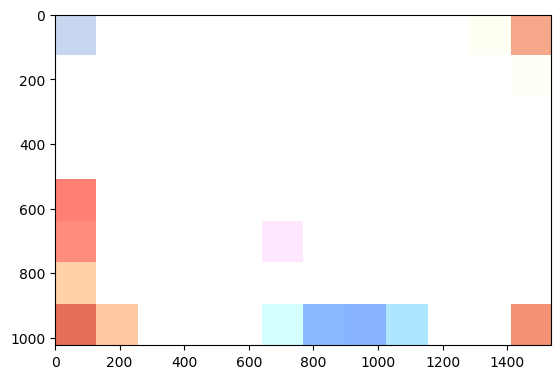

In [34]:
if use_overlap:
    for exp_code in exp_codes:
        if run_heatmap_dict:
            generate_heatmap_dict(exp_code, use_overlap)
        if run_draw_heatmaps:
            draw_heatmaps_overlap(exp_code, cmap)
else:
    for exp_code in exp_codes:
        if run_heatmap_dict:
            generate_heatmap_dict(exp_code)
        if run_draw_heatmaps:
            draw_heatmaps(exp_code, cmap)